In [22]:
import pandas as pd
import igraph as ig
import matplotlib.pyplot as plt
import numpy as np

In [23]:
df = pd.read_csv('../debate_datasets/debate_4000 bambini morti i.csv')
df.head()

,comment_id,post_id,debate_group,comment_user_name,commented_user_name,comment_body,comment_score
0,k7e1uo7,17lese9,4,TheNomadologist,IuvenisCogitans,"Allora, i paesi che hanno votato contro sono s...",0
1,k7dux9e,17lese9,4,TheNomadologist,IuvenisCogitans,Aspetta non capisco esattamente cosa ti stai c...,15
2,k7dvidh,17lese9,4,TheNomadologist,TaskStreet896,L'astensione dell' India non è stata affatto i...,7
3,k7j7qn3,17lese9,4,IronHeart29,HentaiExxxpert,E per difenderci apriremo il fuoco nella prima...,1
4,k7hdejy,17lese9,4,NjxNaDxb,innerfrei,OP paventava una soluzione politica. \n\nIl pr...,2


In [24]:
debate = df


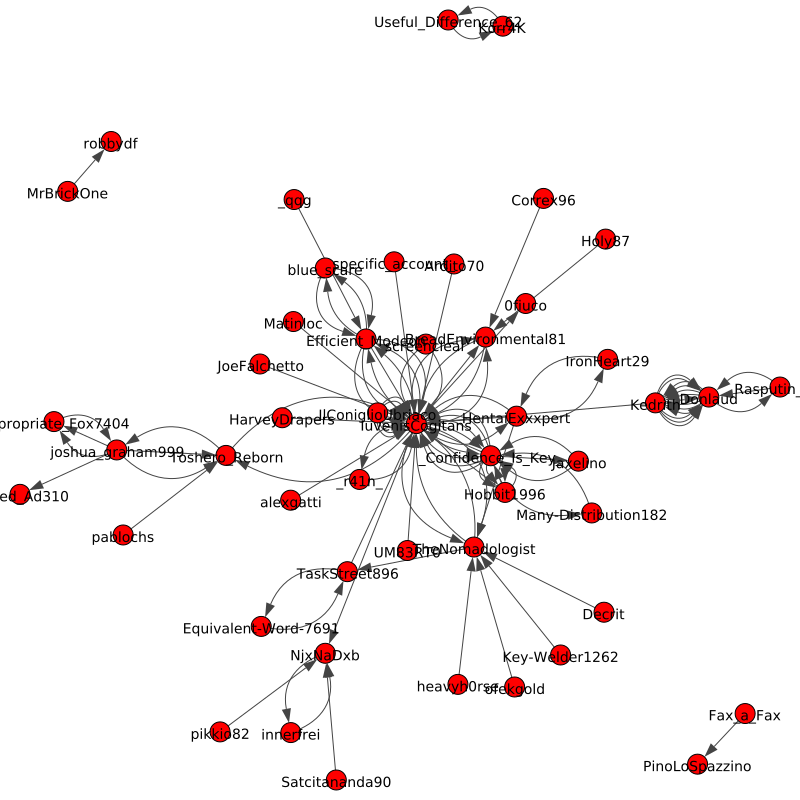

In [25]:
graph = ig.Graph(directed=True)
graph.add_vertex(name='root', label='root')
for comment in debate.iterrows():
    if comment[1]['comment_user_name'] not in graph.vs['name']:
        graph.add_vertex(name=comment[1]['comment_user_name'], label=comment[1]['comment_user_name'])
    if comment[1]['commented_user_name'] not in graph.vs['name']:
        graph.add_vertex(name=comment[1]['commented_user_name'], label=comment[1]['commented_user_name'])
    graph.add_edge(comment[1]['comment_user_name'], comment[1]['commented_user_name'])
    

graph.delete_vertices('root')
ig.plot(graph, bbox=(0, 0, 800,800))

# Metriche di valutazione dei grafi di dibattitio

## Metriche sul POST

### Calcolo dell' average degree
Calcolando l'average degree di ciascun post, è possibile farsi un'idea generale di quanto gli utenti tendono ad interagire tra di loro 

In [26]:
def degree_distribution(graph):
    degree = graph.degree()
    n = graph.vcount()
    degree = np.array(degree)

    return 1/n * sum(degree)

print(degree_distribution(graph))

4.612244897959183


### Distribuzione dei gradi
Questo grafico ci permette di osservare la distribuzione dei gradi di ogni nodo all'interno del grafo, offrendo una visione chiara del livello di interazione degli utenti. **Qual è la percentuale di utenti che hanno interagito poco/tanto con il post?**

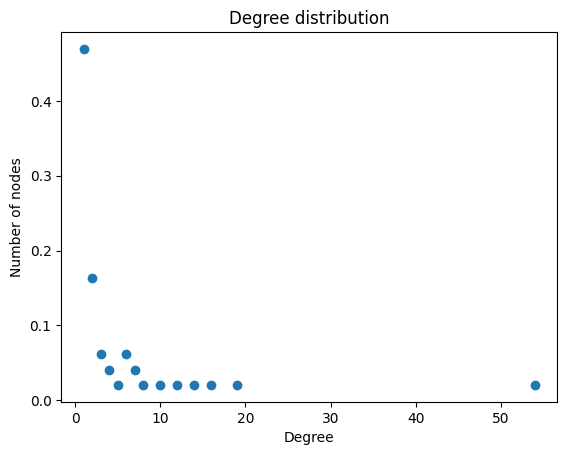

In [27]:

def compute_degree_distribution(graph):
    degree = graph.degree()
    x_label = np.unique(degree)
    degree = np.array(degree)
    y = []
    for i in x_label:
        y.append(sum(degree == i)/ len(degree)) 
    plt.scatter(x_label, y)
    plt.xlabel('Degree')
    plt.ylabel('Number of nodes')
    plt.title('Degree distribution')
    plt.show()

compute_degree_distribution(graph)

## Metriche sul Dibattito

### Coefficiente di clustering medio

Tramite il coefficiente di clustring medio possiamo ottenere una misura golbale del grado di coesione degli utenti all'interno della dibattito, ovvero quanto gli utenti hanno interagito tra di loro all'interno della discussione in questione.

In [28]:
def compute_average_clustering_coefficient(graph):
    return graph.transitivity_undirected()

print(compute_average_clustering_coefficient(graph))

0.03409090909090909
